In [1]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HugginFace Inc. team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
# 이 코드는 인라이플 버트이해하기 발표자료를 참고했음을 밝힙니다.
# Note that this code refers to the Understanding Enliple Bert presentation.

# Bert Model

<img src="https://user-images.githubusercontent.com/1250095/49935094-73f99c80-ff13-11e8-8ba5-50a008ed4d20.png" />

BERT는 트랜스포머의 인코더 부분만 사용한다. 트랜스포머와 달리 Positional Encoding 대신 Positional Embedding을 사용한다.

In [4]:
%matplotlib inline
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import numpy as np
import six

from argparse import Namespace

## Config

BERT 모델을 구성하기에 앞서 모델의 설정을 위해 Config 클래스를 만든다.

In [2]:
class BertConfig(object):
    """
    Configuration class to store the configuration of a `BertModel`.
    `BertModel`의 설정을 저장하는 설정 클래스입니다.
    """
    
    def __init__(self,
                vocab_size,
                hidden_size=768, 
                num_hidden_layers=12, # base model은 12개의 레이어
                num_attention_heads=12, # base model은 12개의 어텐션 헤드
                intermediate_size=3072, 
                hidden_act="gelu",
                hidden_dropout_prob=0.1,
                attention_probs_dropout_prob=0.1,
                max_position_embeddings=512,
                type_vocab_size=16,
                initializer_range=0.02):
        """Constructs BertConfig.

        Args:
            vocab_size: Vocabulary size of `inputs_ids` in `BertModel`.
                                버트 모델의 inputs_ids의 단어 크기
                                그럼 inputs_ids는? 토큰을 아이디로 바꾼 값
                                tokenizer.convert_tokens_to_ids(tokens)
                        
            hidden_size: Size of the encoder layers and the pooler layer.
                                인코더 레이어와 pooler 레이어의 크기
                        
            num_hidden_layers: Number of hidden layers in the Transformer encoder.
                                트랜스포머 인코더의 히든 레이어 개수
                                
            num_attention_heads: Number of attention heads for each attention layer in
                the Transformer encoder.
                                트랜스포머 인코더의 어텐션 헤드 개수
                                
            intermediate_size: The size of the "intermediate" (i.e., feed-forward)
                layer in the Transformer encoder.
                                트랜스포머 인코더의 feed-forward 레이어의 크기
                                
            hidden_act: The non-linear activation function (function or string) in the
                encoder and pooler.
                                비선형 활성화 함수 
                            
            hidden_dropout_prob: The dropout probabilitiy for all fully connected
                layers in the embeddings, encoder, and pooler.
                                임베딩, 인코더, 풀러 안의 완전 연결 레이어 드롭아웃 확률
                                
            attention_probs_dropout_prob: The dropout ratio for the attention
                probabilities.
                                어텐션 드롭아웃
                                
            max_position_embeddings: The maximum sequence length that this model might
                ever be used with. Typically set this to something large just in case
                (e.g., 512 or 1024 or 2048).
                                가장 긴 시퀀스의 길이 제한 
                                
            type_vocab_size: The vocabulary size of the `token_type_ids` passed into
                `BertModel`.
                                ?
                                
            initializer_range: The sttdev of the truncated_normal_initializer for
                initializing all weight matrices.
                                ?
        """
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.hidden_act = hidden_act
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = hidden_dropout_prob
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.initializer_range = initializer_range

    @classmethod
    def from_dict(cls, json_object):
        """Constructs a `BertConfig` from a Python dictionary of parameters."""
        config = BertConfig(vocab_size=None)
        for (key, value) in six.iteritems(json_object):
            config.__dict__[key] = value
        return config

    @classmethod
    def from_json_file(cls, json_file):
        """Constructs a `BertConfig` from a json file of parameters."""
        with open(json_file, "r") as reader:
            text = reader.read()
        return cls.from_dict(json.loads(text))

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

BERT를 초기화 하기 위해 필요한 설정들이다. 

In [5]:
BERT_CONFIG={
    'bert_config_file' : 'bert_config.json',
    'vocab_file' : 'vocab.txt',
    'output_dir' : 'output',
    'train_file' : 'train.json',
    'predict_file' : 'dev.json',
    'init_checkpoint': None, ## checkpint 파일명 or None
    'do_lower_case' : False, 
    'max_seq_length' : 384,
    'doc_stride' : 128,
    'max_query_length' : 64,
    'do_train' : False,
    'do_predict' : False,
    'do_chat' : True,
    'train_batch_size' : 32,
    'predict_batch_size' : 8,
    'learning_rate' : 5e-5,
    'num_train_epochs' : 3.0,
    'warmup_proportion' : 0.1,
    'save_checkpoints_steps' : 1000,
    'iterations_per_loop' : 1000,
    'n_best_size' : 20,
    'max_answer_length' : 30,
    'verbose_logging' : False,
    'no_cuda' : False,
    'local_rank' : -1,
    'accumulate_gradients' : 1,
    'seed' : 42,
    'gradient_accumulation_steps' : 1
}

In [9]:
args = Namespace(**BERT_CONFIG)

# BERT_CONFIG.do_train -> 불가능
args.do_train

False

## GELU

Gaussian Error Linear Units
<img src="https://qph.c7.quoracdn.net/main-qimg-afa9fa5305569f7c9f028271a00cfacf" />
BERT는 비선형성을 위한 활성화 함수로 GELU를 사용합니다. GELU는 확률론적 개념을 도입하여 엘루보다 계산 비용이 저렴하고 빠르게 수렴합니다. 
exp()이나 σ()는 계산 비용이 많이 듭니다. 피드 포워드 층의 활성화 함수로 사용됩니다.

Gaussian Error Linear Unit(GELU)

\begin{align}
f(x) &= 0.5x(1 + tanh[ \sqrt{2/\pi}(x + 0.044715x^3)]) \\
     &or \\
     &= x \sigma(1.702x)
\end{align}

In [17]:
def gelu(x):
    """
    Implementation of gelu activation function.
    gelu 함수 구현
    """
    
    # return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / x) * (x + 0.044715 * math.pow(x, 3))))
    # OpenAI GPT's gelu is slightly different.
    # OpenAI GPT의 갤루는 조금 다릅니다.
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [6]:
help(torch.erf)

Help on built-in function erf:

erf(...)
    erf(tensor, out=None) -> Tensor
    
    Computes the error function of each element. The error function is defined as follows:
    
    .. math::
        \mathrm{erf}(x) = \frac{2}{\sqrt{\pi}} \int_{0}^{x} e^{-t^2} dt
    
    Args:
        tensor (Tensor): the input tensor
        out (Tensor, optional): the output tensor
    
    Example::
    
        >>> torch.erf(torch.tensor([0, -1., 10.]))
        tensor([ 0.0000, -0.8427,  1.0000])



\begin{align}
\mathrm{erf}(x) = \frac{2}{\sqrt{\pi}} \int_{0}^{x} e^{-t^2} dt
\end{align}

In [18]:
x = torch.tensor([[1.0], [2.0]])
gelu(x)

tensor([[0.8413],
        [1.9545]])

In [21]:
x = torch.tensor(np.arange(-1, 1, 0.001))

In [25]:
y = gelu(x)

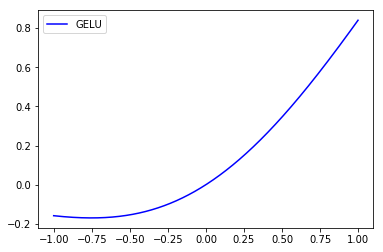

In [34]:
plt.plot(x.numpy(), y.numpy(), 'b', label='GELU')
plt.legend()

## Embedding

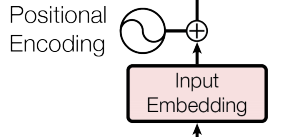

BERT는 Positional Encoding 대신, Positional Embedding을 사용한다.

*   토큰 임베딩: 입력 단어가 단어장(Vocab)에 몇 번째 단어인지 나타냄
*   세그먼트 임베딩: 두 문장 중 앞 문장인지 뒷 문장인지 구분함
*   포지션 임베딩: 문장 내 단어의 순번을 나타냄

세 임베딩을 더한후 LayerNorm 과 Dropout 을 적용한다. 그 결과값은 인코더의 입력값이 된다. 

In [11]:
class BERTEmbeddings(nn.Module):
    # TODO: config 클래스를 받는다. 
    # config에는 하이퍼파라미터에 대한 정보가 담겨있다.
    def __init__(self, config): 
        super(BERTEmbeddings, self).__init__()
        """
        Construct the embedding module from word, position and token_type embeddings.
        
        3가지 임베딩이 필요하다
        """
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        # hidden_size=768 -> 특징을 담는 피처 사이즈
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        # max_position_size=512 -> 최대 시퀀스 길이
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)
        # type_vocab_size=16
        
        """
        세 개의 임베딩 결과 값을 합하여 LayerNorm 과 Dropout 을 거쳐야 한다.
        """
        # TODO: layer normalize 를 해야한다.
        # TODO: dropout 층 생성 해야 한다.
        
        # self.LayerNorm = BERTLayerNorm(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
    
    def forward(self, input_ids, token_type_ids=None):
        # 1 input ids & postion ids & token_type ids 생성
        
        # 2 각 임베딩을 통해 임베딩 벡터 생성
        
        # 3 임베딩 결과들을 더한 후 LayerNorm & Dropout을 하여 인코더 입력값 생성
        
        # 4 return embeddings
        pass